<a href="https://colab.research.google.com/github/Aqsa0308/Projects/blob/main/Elile_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import json
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
# Load the JSON file
with open('/content/new_measurements.json', 'r') as file:
    df = json.load(file)

# Inspect the data structure
print(df.keys())
print(df['data'][:2])  # Print a sample of the data for initial exploration

dict_keys(['status', 'data'])
[{'tid': 'voltage_sensor_0', 'timestamps': ['2022-05-06 11:19:22.749560', '2022-05-06 11:19:25.749560', '2022-05-06 11:19:29.749560', '2022-05-06 11:19:30.749560', '2022-05-06 11:19:32.749560', '2022-05-06 11:19:36.749560', '2022-05-06 11:19:37.749560', '2022-05-06 11:19:40.749560', '2022-05-06 11:19:42.749560', '2022-05-06 11:19:43.749560', '2022-05-06 11:19:47.749560', '2022-05-06 11:19:50.749560', '2022-05-06 11:19:52.749560', '2022-05-06 11:19:54.749560', '2022-05-06 11:19:57.749560', '2022-05-06 11:20:00.749560', '2022-05-06 11:20:04.749560', '2022-05-06 11:20:05.749560', '2022-05-06 11:20:08.749560', '2022-05-06 11:20:12.749560', '2022-05-06 11:20:14.749560', '2022-05-06 11:20:17.749560', '2022-05-06 11:20:18.749560', '2022-05-06 11:20:22.749560', '2022-05-06 11:20:23.749560', '2022-05-06 11:20:26.749560', '2022-05-06 11:20:27.749560', '2022-05-06 11:20:29.749560', '2022-05-06 11:20:33.749560', '2022-05-06 11:20:37.749560', '2022-05-06 11:20:41.74956

In [92]:
# Convert to DataFrame
sensors_data = pd.json_normalize(df['data'])

# Expand each row to match timestamp-value pairs for each sensor
sensors_expanded = sensors_data.explode(['timestamps', 'values']).reset_index(drop=True)
sensors_expanded['timestamps'] = pd.to_datetime(sensors_expanded['timestamps'])
sensors_expanded['values'] = pd.to_numeric(sensors_expanded['values'], errors='coerce')

# Display the head of the expanded data
print(sensors_expanded.head())

                tid                 timestamps  values
0  voltage_sensor_0 2022-05-06 11:19:22.749560    23.0
1  voltage_sensor_0 2022-05-06 11:19:25.749560    26.0
2  voltage_sensor_0 2022-05-06 11:19:29.749560    25.8
3  voltage_sensor_0 2022-05-06 11:19:30.749560    27.3
4  voltage_sensor_0 2022-05-06 11:19:32.749560    22.7


In [102]:
# To find out outliers
total_outliers_detected = 0

# Function to detect outliers without removing them
def detect_outliers(df):
    global total_outliers_detected
    Q1 = df['values'].quantile(0.25)
    Q3 = df['values'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    outliers = df[(df['values'] < lower_bound) | (df['values'] > upper_bound)]
    total_outliers_detected += len(outliers)  # count of outliers
    return outliers  # Return the outliers found

# Apply outlier detection per sensor to get total outliers
all_outliers = sensors_expanded.groupby('tid').apply(detect_outliers).reset_index(drop=True)
print("Total outliers detected:", total_outliers_detected)  # Total detected outliers

Total outliers detected: 40000


<ipython-input-102-b34bd344880c>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_outliers = sensors_expanded.groupby('tid').apply(detect_outliers).reset_index(drop=True)


In [101]:
# Outliers removal
outliers_count = 0

# Function to remove outliers
def remove_outliers(df):
    global outliers_count
    Q1 = df['values'].quantile(0.25)
    Q3 = df['values'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    outliers = df[(df['values'] < lower_bound) | (df['values'] > upper_bound)]
    outliers_count += len(outliers)  # Count removed outliers
    return df[(df['values'] >= lower_bound) & (df['values'] <= upper_bound)]

# Apply outlier removal per sensor
sensors_no_outliers = sensors_expanded.groupby('tid').apply(remove_outliers).reset_index(drop=True)

# Output results

print("Total outliers removed:", outliers_count)  # Total removed outliers

Total outliers removed: 40000


<ipython-input-101-4a7e39656218>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sensors_no_outliers = sensors_expanded.groupby('tid').apply(remove_outliers).reset_index(drop=True)


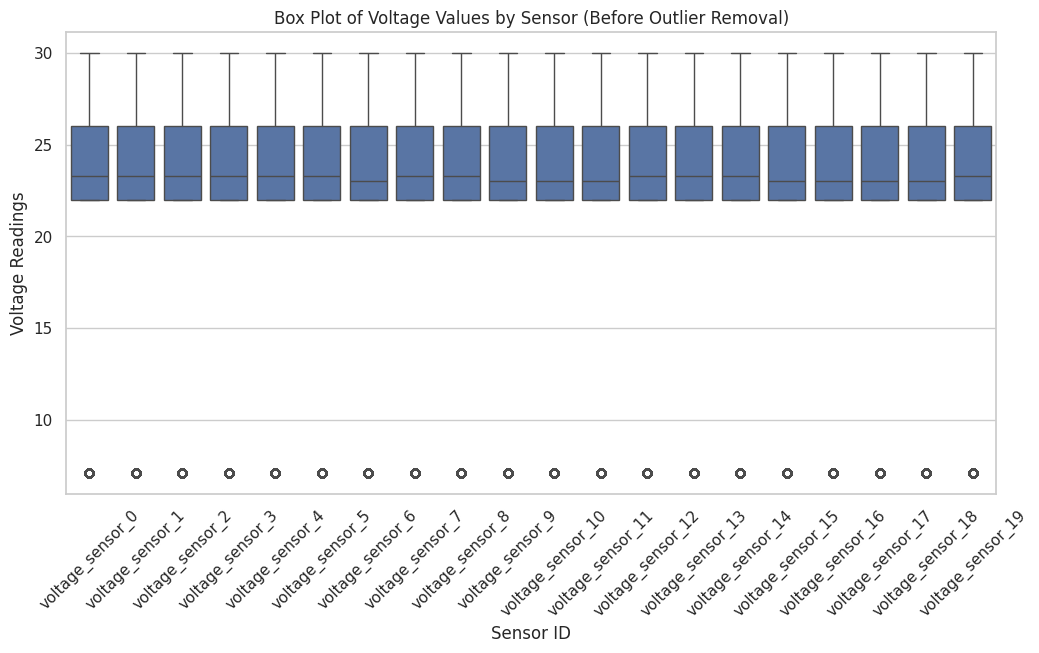

In [103]:


# Before removing outliers: Plot box plots for each sensor
plt.figure(figsize=(12, 6))
sns.boxplot(x='tid', y='values', data=sensors_expanded)
plt.title("Box Plot of Voltage Values by Sensor (Before Outlier Removal)")
plt.xlabel("Sensor ID")
plt.ylabel("Voltage Readings")
plt.xticks(rotation=45)
plt.show()

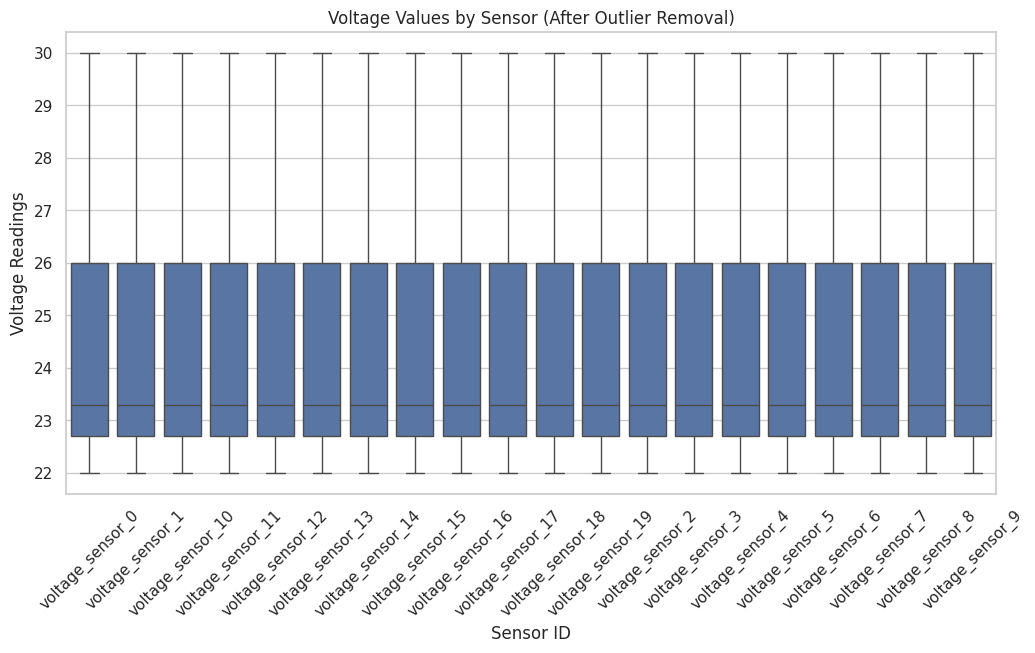

Total outliers detected: 40000
Total outliers removed: 40000


In [106]:

# After removing outliers: Plot box plots for each sensor
plt.figure(figsize=(12, 6))
sns.boxplot(x='tid', y='values', data=sensors_no_outliers)
plt.title("Voltage Values by Sensor (After Outlier Removal)")
plt.xlabel("Sensor ID")
plt.ylabel("Voltage Readings")
plt.xticks(rotation=45)
plt.show()

# Output total detected and removed outliers
print("Total outliers detected:", total_outliers_detected)
print("Total outliers removed:", outliers_count)

In [94]:
# Count null values and drop #
empty_values_count = sensors_no_outliers['values'].isnull().sum()
sensors_no_outliers = sensors_no_outliers.dropna(subset=['values']).reset_index(drop=True)

print("Total empty values removed:", empty_values_count)


Total empty values removed: 0


In [95]:
# Calculate mean and SD to find average voltage and its variation from mean value#
sensor_stats = sensors_no_outliers.groupby('tid')['values'].agg(['mean', 'std']).reset_index()
sensor_stats.columns = ['Sensor ID', 'Mean Value', 'Standard Deviation']
print(sensor_stats)


            Sensor ID  Mean Value  Standard Deviation
0    voltage_sensor_0   24.623157            2.529138
1    voltage_sensor_1   24.605665            2.521813
2   voltage_sensor_10   24.596521            2.522036
3   voltage_sensor_11   24.595757            2.524925
4   voltage_sensor_12   24.627425            2.528135
5   voltage_sensor_13   24.625929            2.516782
6   voltage_sensor_14   24.621470            2.519234
7   voltage_sensor_15   24.588586            2.518973
8   voltage_sensor_16   24.617596            2.535277
9   voltage_sensor_17   24.584684            2.528989
10  voltage_sensor_18   24.595557            2.525329
11  voltage_sensor_19   24.601852            2.524379
12   voltage_sensor_2   24.612705            2.527688
13   voltage_sensor_3   24.628836            2.544890
14   voltage_sensor_4   24.611867            2.513876
15   voltage_sensor_5   24.604542            2.522182
16   voltage_sensor_6   24.609424            2.530097
17   voltage_sensor_7   24.6

In [96]:
# To check peak and low voltage time #
peak_times = sensors_no_outliers.loc[sensors_no_outliers.groupby('tid')['values'].idxmax()][['tid', 'timestamps', 'values']]
low_times = sensors_no_outliers.loc[sensors_no_outliers.groupby('tid')['values'].idxmin()][['tid', 'timestamps', 'values']]

peak_times.columns = ['Sensor ID', 'Peak Voltage Time', 'Peak Voltage']
low_times.columns = ['Sensor ID', 'Low Voltage Time', 'Low Voltage']

print("Peak Voltage Times:")
print(peak_times)
print("\nLow Voltage Times:")
print(low_times)


Peak Voltage Times:
                Sensor ID          Peak Voltage Time  Peak Voltage
7        voltage_sensor_0 2022-05-06 11:19:40.749560          30.0
25989    voltage_sensor_1 2022-05-06 11:19:23.749560          30.0
51980   voltage_sensor_10 2022-05-06 11:19:54.749560          30.0
77989   voltage_sensor_11 2022-05-06 11:19:30.749560          30.0
103982  voltage_sensor_12 2022-05-06 11:19:29.749560          30.0
129926  voltage_sensor_13 2022-05-06 11:20:33.749560          30.0
155954  voltage_sensor_14 2022-05-06 11:19:41.749560          30.0
182025  voltage_sensor_15 2022-05-06 11:20:25.749560          30.0
208124  voltage_sensor_16 2022-05-06 11:19:29.749560          30.0
234139  voltage_sensor_17 2022-05-06 11:19:39.749560          30.0
260179  voltage_sensor_18 2022-05-06 11:20:20.749560          30.0
286180  voltage_sensor_19 2022-05-06 11:19:36.749560          30.0
312205   voltage_sensor_2 2022-05-06 11:19:28.749560          30.0
338222   voltage_sensor_3 2022-05-06 11:21

In [97]:
anomalies_count = 0
anomaly_data = []

# Anomaly detection
for sensor_id, sensor_data in sensors_no_outliers.groupby('tid'):
    mean_value = sensor_data['values'].mean()
    std_dev = sensor_data['values'].std()
    threshold = mean_value + 3 * std_dev

    anomalies = sensor_data[sensor_data['values'] > threshold]
    anomalies_count += len(anomalies)
    if not anomalies.empty:
        anomaly_data.append((sensor_id, anomalies['timestamps'].tolist(), anomalies['values'].tolist()))

print("Total potential anomalies found:", anomalies_count)
print("Anomaly Data (Sensor ID, Timestamps, Values):")
print(anomaly_data)


Total potential anomalies found: 0
Anomaly Data (Sensor ID, Timestamps, Values):
[]
